## A tarefa proposta é analisar e tentar remover todo o ruído que vocês conseguirem utilizando o método computacional que preferirem, preservando ao máximo o sinal. É importante também gerar uma visualização dos traços no tempo, e da FFT 2D da imagem. A entrega consistirá de uma apresentação de duração entre 10 a 15 min, dos resultados e da metodologia utilizada para remover o ruído (filtros empregados, tratamento do dado, etc.)  contendo sua análise e interpretação das imagens e dos resultados gerados.

## Somente a primeira das imagens (traços por shot x número de amostras) dessa sísmica sintética foi deixada no arquivo. Preservamos o cabeçalho, mas os traços das demais imagens foram todos preenchidos com zeros.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import obspy
from scipy.fftpack import fft2, fftshift
import functions as fun

## 1- Pre-stack seismic data processing.

### Reading seismic data:
   - Read seismic data from appropriate file formats (e.g., SEG-Y) using a seismic data reading library such as <a href="https://docs.obspy.org/"><code>obspy</code></a>

In [2]:
# Path to the SEG-Y file
seg_y_file = "Dataset_Sintetico_02_shot0.sgy"
# Reading seismic data using the ObsPy library
stream = obspy.read(seg_y_file, format='SEGY')

In [3]:
# header of the first trace 
stream[0].stats

         network: 
         station: 
        location: 
         channel: 
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T00:00:08.000000Z
   sampling_rate: 250.0
           delta: 0.004
            npts: 2001
           calib: 1.0
         _format: SEGY
            segy: AttribDict({'trace_header': LazyTraceHeaderAttribDict({'unpacked_header': b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xfd\x12\x00\x00\x03\xe8\x00\x00\x03\xe8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\x9c\xff\x9c\x00\x00\xc3P\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\xd1\x0f\xa0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

In [4]:
# Parameters
sampling_freq = stream[0].stats.sampling_rate # Hz
start_time = obspy.UTCDateTime('1970-01-01T00:00:00.000000Z')
num_traces = len(stream)  # Total number of traces.
num_samples = stream[0].stats.npts  # Number of samples in each trace.

print ('sampling freq: {} Hz'.format(sampling_freq))
print ('start time: {} '.format(start_time))
print ('Total number of traces: {}'.format(num_traces))
print ('Number of samples in each trace: {}'.format(num_samples))

sampling freq: 250.0 Hz
start time: 1970-01-01T00:00:00.000000Z 
Total number of traces: 89280
Number of samples in each trace: 2001


### Plotting of raw seismic data

In [5]:
traces = []
# Loop through traces in the SEG-Y file
for trace in stream.traces:
    amplitudes = trace.data
    header = trace.stats
    dt = trace.stats['delta']
    if np.any(amplitudes != 0): # remove trace with amplitude = 0
        # Create a Trace object with the original data and header
        trace_obj = obspy.Trace(data=amplitudes, header=header)
        traces.append(trace_obj)        

In [6]:
# Convert the traces to a Stream object
st_raw= obspy.Stream(traces)

In [7]:
# New parameters
sampling_freq = st_raw[0].stats.sampling_rate # Hz
start_time = obspy.UTCDateTime('1970-01-01T00:00:00.000000Z')
num_traces = len(st_raw)  # Total number of traces.
num_samples = st_raw[0].stats.npts  # Number of samples in each trace.

print ('sampling freq: {} Hz'.format(sampling_freq))
print ('start time: {} '.format(start_time))
print ('Total number of traces: {}'.format(num_traces))
print ('Number of samples in each trace: {}'.format(num_samples))

sampling freq: 250.0 Hz
start time: 1970-01-01T00:00:00.000000Z 
Total number of traces: 992
Number of samples in each trace: 2001


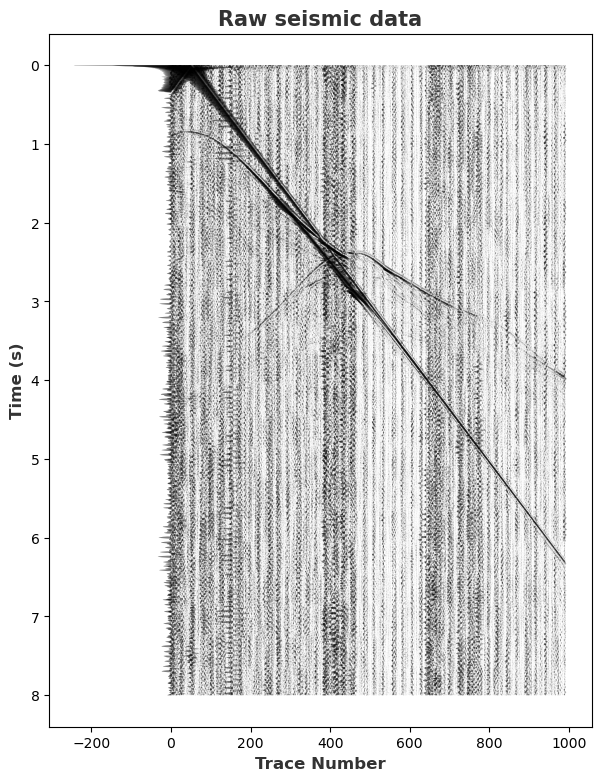

In [8]:
fun.raw_wiggle_plot(st_raw,
                    dt,
                    title = 'Raw seismic data',
                    figsize = (7,9),
                    filename = 'original_data.png')

### Apply noise removal techniques to improve seismic data quality, such as frequency filtering

In [9]:
# Store the seismic data in a suitable data structure such as a numpy array.
data = []
for trace in st_raw[:num_traces]:
    data.append(trace.data[:num_samples])
data = np.array(data)

- Analysis of outliers in amplitude values

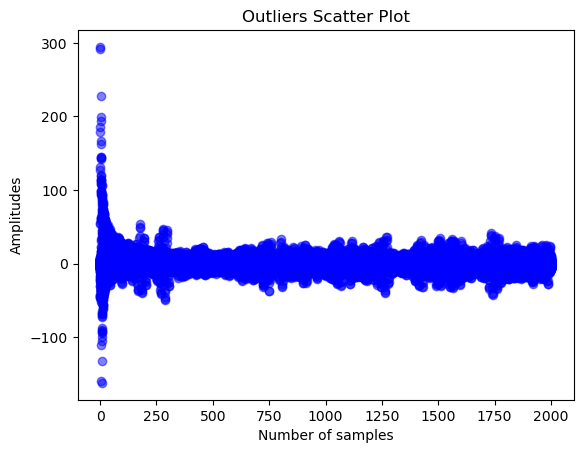

In [10]:
# plot for analysis of outliers in amplitude values
fun.plot_outliers_scatter(data,filename = "amplitude_analysis.png")

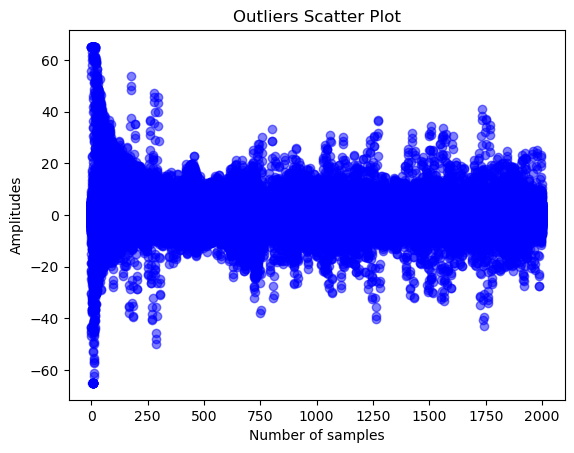

In [11]:
# apply filtering to remove outliers, the choice requires analyzing the graph with the amplitude values
data_remove_outliers = []
for trace in st_raw[:num_traces]:
    filtered_trace = trace.copy()
    # The filtered values are set to the corresponding limit.
    filtered_trace.data[filtered_trace.data > 65] = 65
    filtered_trace.data[filtered_trace.data < -65] = -65
    data_remove_outliers.append(filtered_trace.data[:num_samples])
data_remove_outliers = np.array(data_remove_outliers)

fun.plot_outliers_scatter(data_remove_outliers,filename = "new_amplitude_analysis.png")

- Spectral analysis of raw seismic traces 

In [12]:
st_raw_remove_outliers = obspy.Stream([obspy.Trace(data=data_remove_outliers[i],
                                   header={'starttime': start_time,
                                           'sampling_rate': sampling_freq}) for i in range(num_traces)])

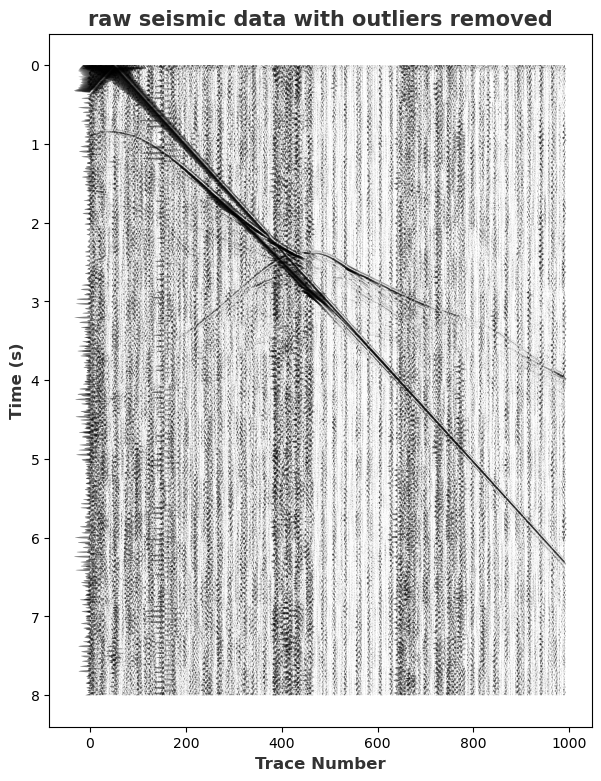

In [13]:
fun.raw_wiggle_plot(st_raw_remove_outliers,
                    dt,
                    title = 'raw seismic data with outliers removed',
                    figsize = (7,9),
                    filename = 'raw_seismic_data_outliers_removed.png')

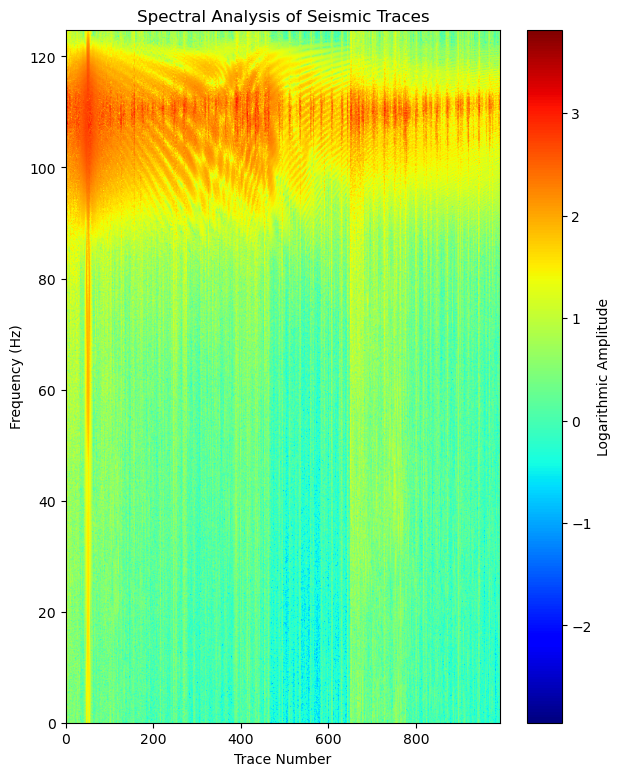

In [14]:
# Get the seismic traces from the stream
traces_ae = [trace.data for trace in st_raw_remove_outliers]
# Parameters
sampling_rate = sampling_freq

# Find the maximum length of the traces
max_length = max(len(trace) for trace in traces_ae)

# Create empty arrays for spectra and frequencies
spectra = np.empty((len(traces_ae), max_length // 2))
frequencies = np.empty((len(traces_ae), max_length // 2))

# Perform spectral analysis for each trace
for i, trace in enumerate(traces_ae):
    # Pad shorter traces with zeros
    padded_trace = np.pad(trace, (0, max_length - len(trace)), 'constant')
    # Perform Fourier transform
    spectrum = np.abs(np.fft.fft(padded_trace))
    # Calculate corresponding frequencies
    freq = np.fft.fftfreq(len(padded_trace), d=1/sampling_rate)[:max_length // 2]
    
    spectra[i] = spectrum[:max_length // 2]
    frequencies[i] = freq

# Plot the spectral analysis
plt.figure(figsize=(7,9))
plt.imshow(np.log10(spectra.T), aspect='auto', cmap='jet', extent=(0, len(traces_ae), frequencies[0, 0], frequencies[0, -1]))
plt.colorbar(label='Logarithmic Amplitude')
plt.xlabel('Trace Number')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Analysis of Seismic Traces')
plt.savefig('Spectral_Analysis_raw_Seismic_Traces.png',dpi = 400, bbox_inches = 'tight')
plt.show()

- Apply a frequency filter to seismic data.

In [15]:
lowcut = 10.0
highcut = 70.0

remove_outliers_data = []
for trace in st_raw_remove_outliers[:num_traces]:
    remove_outliers_data.append(trace.data[:num_samples])
remove_outliers_data = np.array(remove_outliers_data)

filtered_data = fun.frequency_filter(remove_outliers_data,
                                     lowcut,
                                     highcut,
                                     start_time,
                                     sampling_freq,
                                     num_traces)

In [16]:
# Criar uma Stream de obspy a partir dos dados
st_filtered = obspy.Stream([obspy.Trace(data=filtered_data[i],
                                   header={'starttime': start_time,
                                           'sampling_rate': sampling_freq}) for i in range(num_traces)])

- Plot filtered raw seismic data

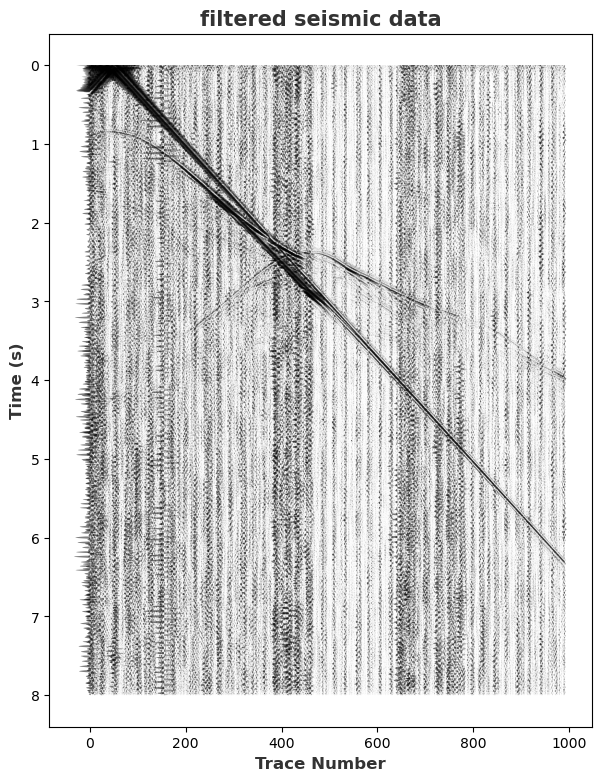

In [17]:
fun.raw_wiggle_plot(st_filtered,
                    dt,
                    title = 'filtered seismic data',
                    figsize = (7,9),
                    filename = 'noise_removal_data.png')

- Spectral analysis of filtered seismic traces 

### Normalize seismic data to ensure consistency in amplitude between seismic traces

- Plot normalized filtered data

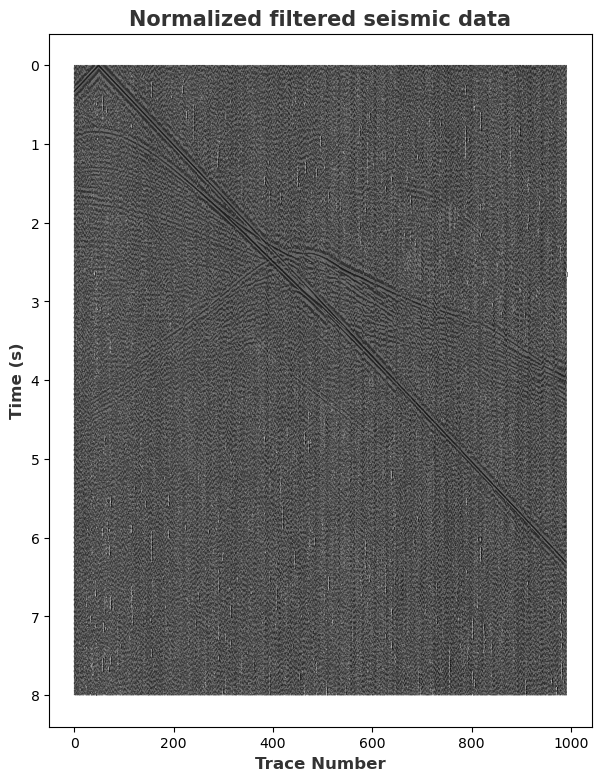

In [18]:
fun.normalized_wiggle_plot(st_filtered,
                           dt,
                           title = 'Normalized filtered seismic data',
                           figsize = (7,9),
                           filename = 'normalized_filtered_data.png')

- Plot normalized raw data

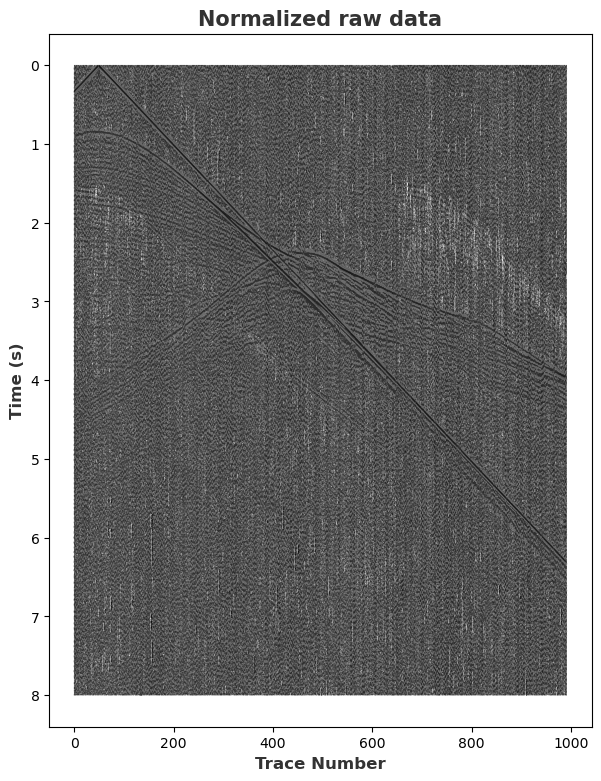

In [19]:
fun.normalized_wiggle_plot(st_raw_remove_outliers,
                           dt,
                           title = 'Normalized raw data',
                           figsize = (7,9),
                           filename = 'normalized_raw_data.png')

### Automatic Gain Control (AGC)

Automatic Gain Control (AGC) é uma técnica utilizada no processamento de dados sísmicos para ajustar automaticamente a amplitude dos traços sísmicos com o objetivo de melhorar a visualização e interpretação dos dados. A ideia principal por trás do AGC é compensar a atenuação das amplitudes com o tempo de percurso das ondas sísmicas.

In [20]:
# Define o comprimento da janela em número de amostras
window_length=0.09
window_size = int(window_length * st_filtered[0].stats.sampling_rate)

trace_agc = []
# Aplica o AGC em cada traço sísmico
for trace in st_filtered:
    # Calcula a amplitude média dentro de cada janela
    amplitudes = np.abs(trace.data)
    smoothed_amplitudes = np.convolve(amplitudes, np.ones(window_size) / window_size, mode='same')
        
    # Calcula o fator de ganho para cada amostra
    gain = np.maximum(smoothed_amplitudes, 1e-10) / amplitudes
        
    # Aplica o ganho aos dados sísmicos
    trace.data *= gain
    trace_agc.append(trace.data)

trace_agc = np.array(trace_agc)

In [21]:
st_filtered_agc = obspy.Stream([obspy.Trace(data=trace_agc[i],
                                   header={'starttime': start_time,
                                           'sampling_rate': sampling_freq}) for i in range(num_traces)])

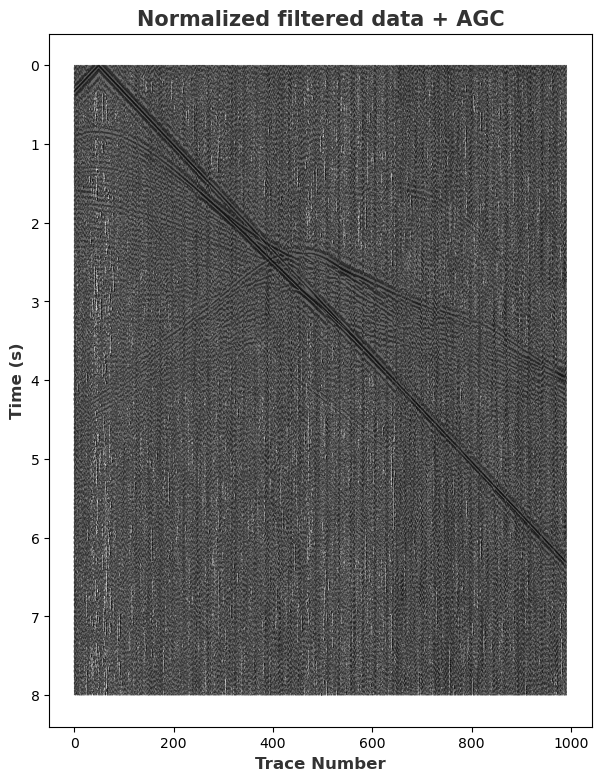

In [22]:
fun.normalized_wiggle_plot(st_filtered_agc,
                           dt, 
                           title = 'Normalized filtered data + AGC',
                           figsize = (7,9),
                           filename = 'Normalized_filtered_data_AGC.png')